In [1]:
import sys
sys.path.append('../')

In [2]:
from scripts import verify_gpu

USE_GPU = verify_gpu.run()

TF Version:  2.1.0
------Devices------
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 552715904954424407
,
 name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5061476352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15944435112524805302
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
--------------------------------
Num GPUs Available:  1
Has gpu:  True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from mrcnn.config import Config

class PredictionConfig(Config):
	NAME = 'kangaroo-prediction-cfg'
	NUM_CLASSES = 2
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
	BACKBONE = "resnet101"
	USE_MINI_MASK = False

config = PredictionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
from scripts.dataset import KangarooDataset

train_set = KangarooDataset()
train_set.load_data('./data/kangaroo/')
train_set.prepare()
print(f'train: ', len(train_set.image_ids))
val_set = KangarooDataset()
val_set.load_data('./data/kangaroo/', is_train=False)
val_set.prepare()
print(f'val: ', len(val_set.image_ids))

train:  131
val:  32


In [5]:
from mrcnn.model import MaskRCNN

model = MaskRCNN(mode='inference', model_dir= './temp/prediction', config= config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
model.load_weights('./model/weights_archive/ak12.resnet101.tf2gpu.modded.sucess01.h5', by_name=True)

In [7]:
# from scripts.evaluate import evaluate_model
# from time import time

# for name, eval_set in [('Training', train_set), ('Validation', val_set)]:
# 	start_train = time()

# 	mAP = evaluate_model(eval_set,model, config)

# 	end_train = time()
# 	minutes = round((end_train - start_train) / 60, 2)
# 	print(f'{name} inference took {minutes} minutes')
# 	print(f'{name} mAP: ', mAP)

In [8]:
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
import numpy as np
import matplotlib.pyplot as plt

In [9]:
from mrcnn.utils import compute_ap

def predict(dataset, image_id, cfg):
	image, _, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
	scaled_image = mold_image(image, config)
	sample = np.expand_dims(scaled_image, 0)
	yhat = model.detect(sample, verbose = 0)

	r = yhat[0]
	AP, _, _, _ = compute_ap(
			gt_bbox, gt_class_id, gt_mask, 
			r['rois'], r['class_ids'], r['scores'], r['masks'])
    
	return image, r, AP

In [29]:
def plot_pred(image, true_masks, yhat, image_temp):
	plt.subplot(1, 2, 1)
	plt.axis('off')
	plt.title(f'Actual {image.shape}')
	plt.imshow(image)
	ax = plt.gca()
	for i in range(true_masks.shape[2]):
		mask = true_masks[:, :, i]
		maskx = np.any(mask, axis=0)
		masky = np.any(mask, axis=1)
		x1 = np.argmax(maskx)
		y1 = np.argmax(masky)
		x2 = len(maskx) - np.argmax(maskx[::-1])
		y2 = len(masky) - np.argmax(masky[::-1])
		w, h = x2-x1, y2-y1
		rect = plt.Rectangle((x1,y1), w,h, fill=False, color='red')
		ax.add_patch(rect)

		# alternative		
		# plt.imshow(true_masks[:,:,i], cmap='gray', alpha = 0.3)

	plt.subplot(1, 2, 2)
	plt.axis('off')
	plt.title(f'Predicted {image_temp.shape}')
	plt.imshow(image_temp)

	ax = plt.gca()
	for box in yhat['rois']:
		y1,x1, y2,x2 = box
		w, h = x2-x1, y2-y1
		rect = plt.Rectangle((x1,y1), w,h, fill=False, color='red')
		ax.add_patch(rect)
	plt.show()

Visualizing image:  11


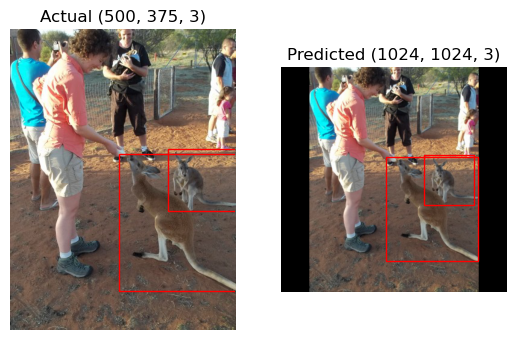

AP:  1.0


In [46]:
from random import random
image_id = round(random() * (len(val_set.image_ids) - 1))
print('Visualizing image: ', image_id)


image_temp, yhat, ap = predict(val_set, image_id, config)
image = val_set.load_image(image_id)
true_masks, _ = val_set.load_mask(image_id)


plot_pred(image, true_masks, yhat, image_temp)
print('AP: ', ap)


In [31]:
for image_id in val_set.image_ids:
	_, _, ap = predict(val_set, image_id, config)
	print(f'Image id: {image_id}, AP: {ap}')


Image id: 0, AP: 1.0
Image id: 1, AP: 1.0
Image id: 2, AP: 1.0
Image id: 3, AP: 1.0
Image id: 4, AP: 1.0
Image id: 5, AP: 0.34375
Image id: 6, AP: 1.0
Image id: 7, AP: 1.0
Image id: 8, AP: 1.0
Image id: 9, AP: 1.0
Image id: 10, AP: 1.0
Image id: 11, AP: 1.0
Image id: 12, AP: 1.0
Image id: 13, AP: 1.0
Image id: 14, AP: 1.0
Image id: 15, AP: 1.0
Image id: 16, AP: 1.0
Image id: 17, AP: 1.0
Image id: 18, AP: 1.0
Image id: 19, AP: 0.5
Image id: 20, AP: 1.0
Image id: 21, AP: 0.6666666865348816
Image id: 22, AP: 1.0
Image id: 23, AP: 1.0
Image id: 24, AP: 1.0
Image id: 25, AP: 1.0
Image id: 26, AP: 1.0
Image id: 27, AP: 1.0
Image id: 28, AP: 1.0
Image id: 29, AP: 1.0
Image id: 30, AP: 1.0
Image id: 31, AP: 1.0


------------------------------------------------
Visualizing image:  5


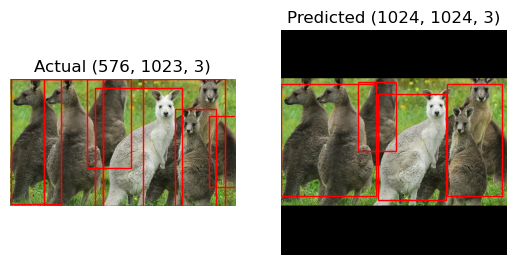

AP:  0.34375
------------------------------------------------
Visualizing image:  19


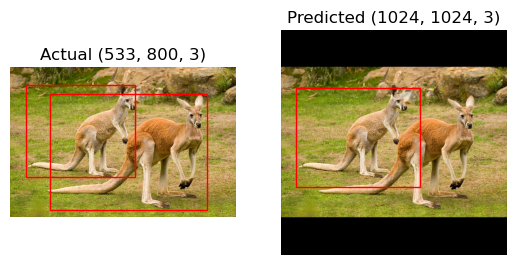

AP:  0.5
------------------------------------------------
Visualizing image:  21


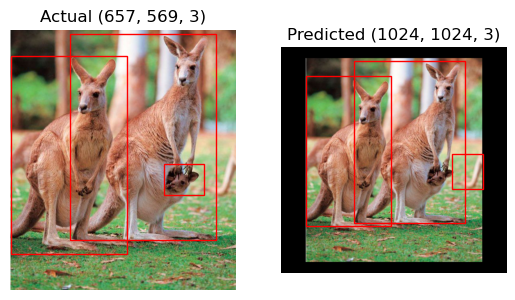

AP:  0.6666666865348816


In [33]:
for image_id in [5,19,21]:
	print('------------------------------------------------')
	print('Visualizing image: ', image_id)


	image_temp, yhat, ap = predict(val_set, image_id, config)
	image = val_set.load_image(image_id)
	true_masks, _ = val_set.load_mask(image_id)


	plot_pred(image, true_masks, yhat, image_temp)
	print('AP: ', ap)


# Test with another dataset
[Link](https://www.kaggle.com/datasets/hugozanini1/kangaroodataset)

In [65]:
from os import listdir
from random import shuffle
class TestDataset(KangarooDataset):
	def load_data(self, dataset_dir, is_train=True):
		self.add_class(self.source, 1, 'kangaroo')

		images_dir = dataset_dir + 'images/'
		annotations_dir = dataset_dir + 'annots/'

		LIMIT = 30
		image_list = listdir(images_dir)
		shuffle(image_list)
		for i, filename in enumerate(image_list[0: LIMIT]):
			# get image id
			image_id = filename[:-4] # skipping file extension '.jpg'
			
			if self.debug and int(image_id) > self.debug_limit: break

			# skip bad ones
			if image_id in self.bad_images: continue

			image_path = images_dir + filename 
			annotation_path = annotations_dir + image_id + '.xml'

			# add to ds
			self.add_image(self.source, image_id=image_id, path=image_path, annotation=annotation_path)

In [66]:
test_set = TestDataset()
test_set.load_data('./data/kangaroo-kaggle/')
test_set.prepare()

------------------------------------------------
Visualizing image:  0


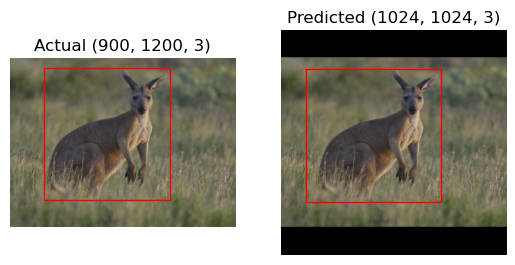

AP:  1.0
------------------------------------------------
Visualizing image:  1


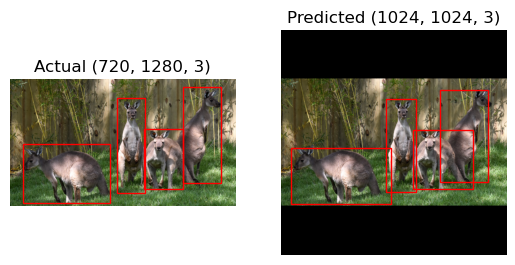

AP:  1.0
------------------------------------------------
Visualizing image:  2


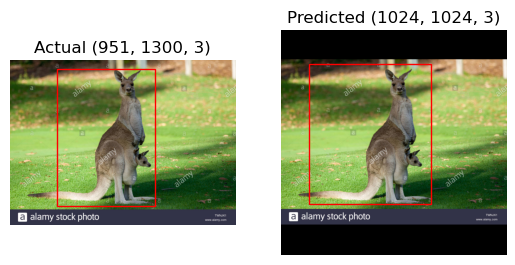

AP:  1.0
------------------------------------------------
Visualizing image:  3


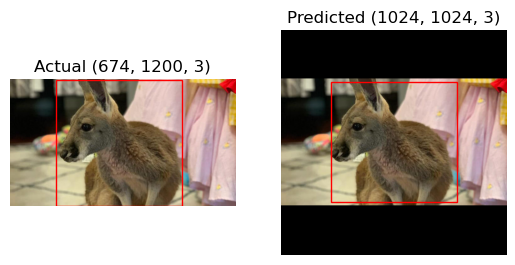

AP:  1.0
------------------------------------------------
Visualizing image:  4


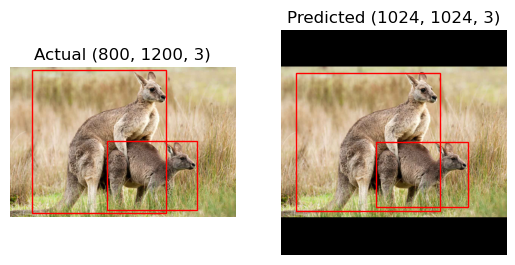

AP:  1.0
------------------------------------------------
Visualizing image:  5


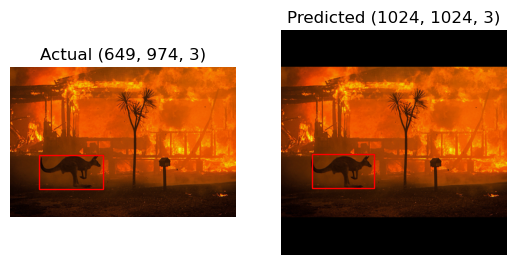

AP:  1.0
------------------------------------------------
Visualizing image:  6


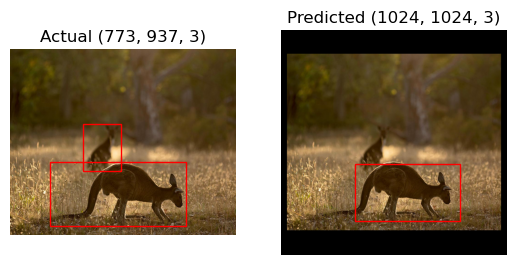

AP:  0.5
------------------------------------------------
Visualizing image:  7


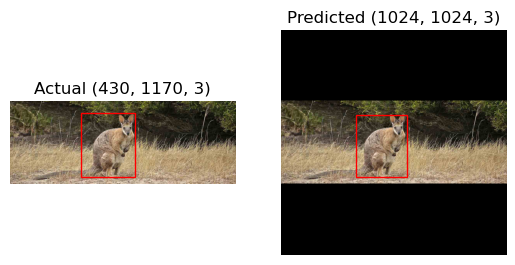

AP:  1.0
------------------------------------------------
Visualizing image:  8


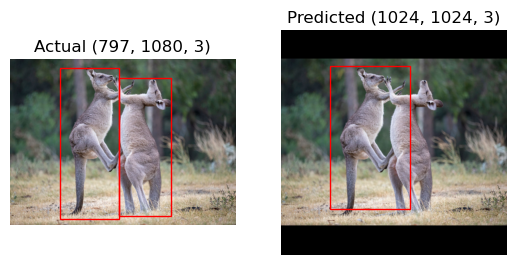

AP:  0.5
------------------------------------------------
Visualizing image:  9


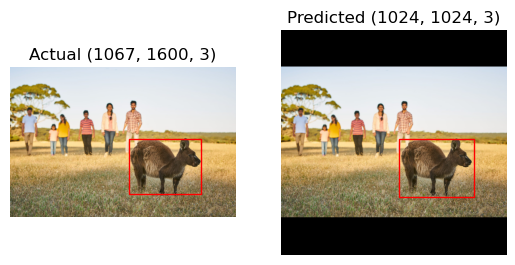

AP:  1.0
------------------------------------------------
Visualizing image:  10


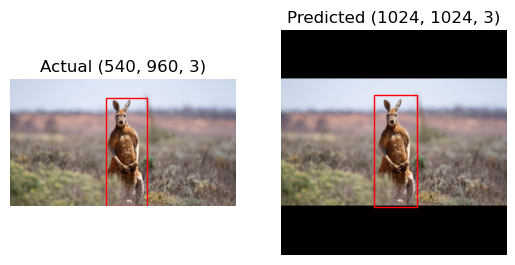

AP:  1.0
------------------------------------------------
Visualizing image:  11


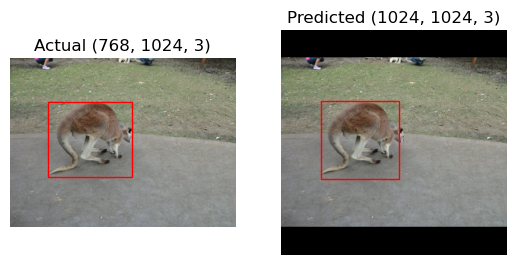

AP:  1.0
------------------------------------------------
Visualizing image:  12


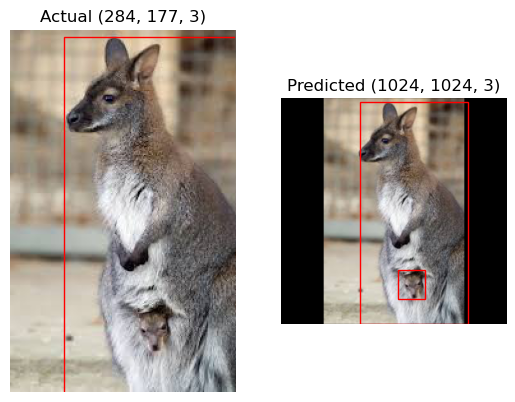

AP:  1.0
------------------------------------------------
Visualizing image:  13


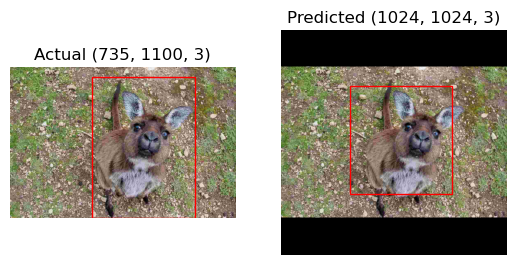

AP:  1.0
------------------------------------------------
Visualizing image:  14


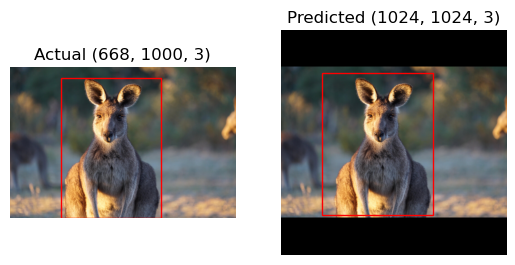

AP:  1.0
------------------------------------------------
Visualizing image:  15


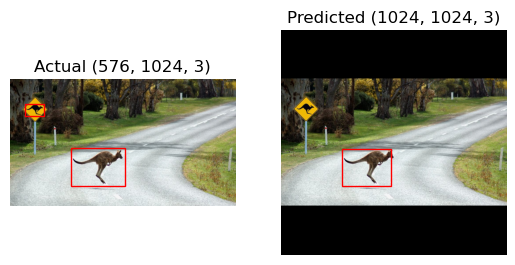

AP:  0.5
------------------------------------------------
Visualizing image:  16


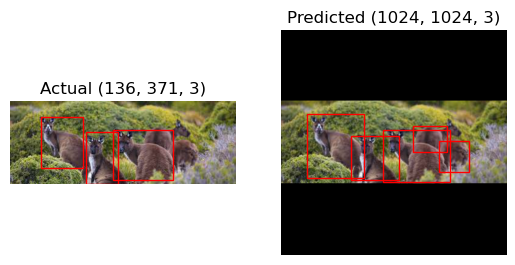

AP:  1.0
------------------------------------------------
Visualizing image:  17


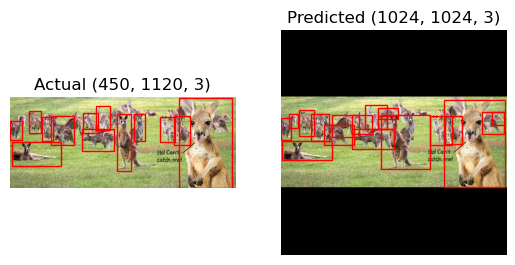

AP:  0.5128205219904581
------------------------------------------------
Visualizing image:  18


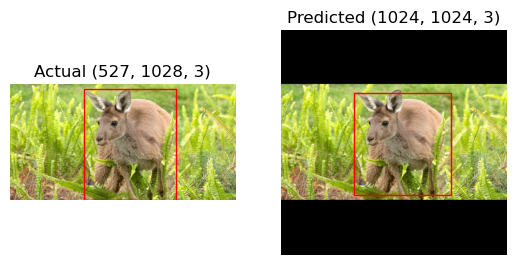

AP:  1.0
------------------------------------------------
Visualizing image:  19


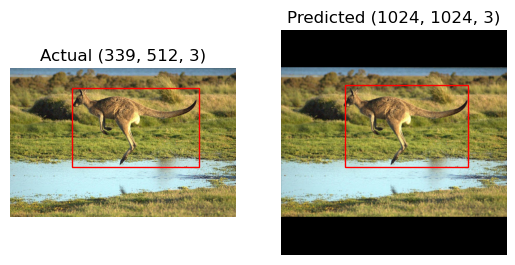

AP:  1.0
------------------------------------------------
Visualizing image:  20


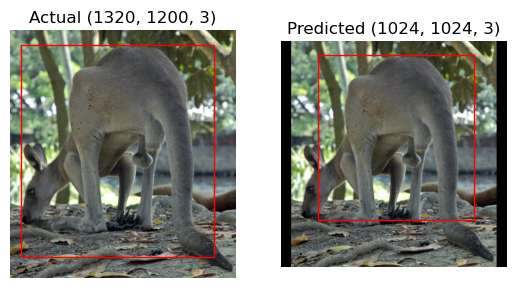

AP:  1.0
------------------------------------------------
Visualizing image:  21


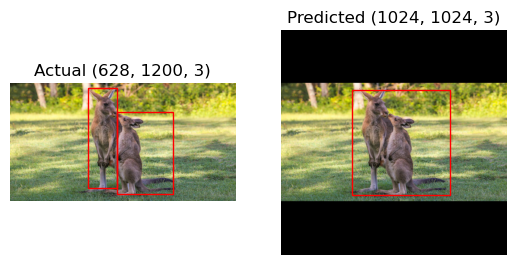

AP:  0.5
------------------------------------------------
Visualizing image:  22


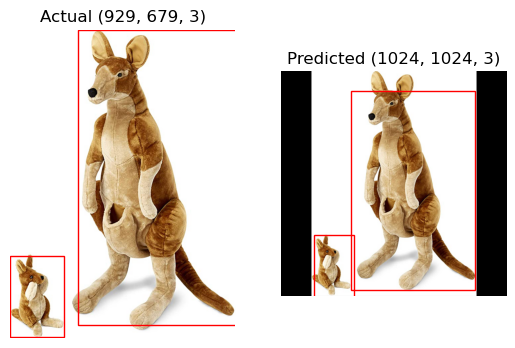

AP:  1.0
------------------------------------------------
Visualizing image:  23


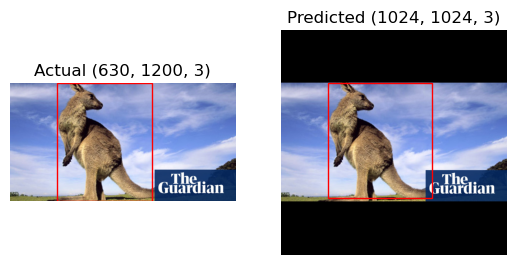

AP:  1.0
------------------------------------------------
Visualizing image:  24


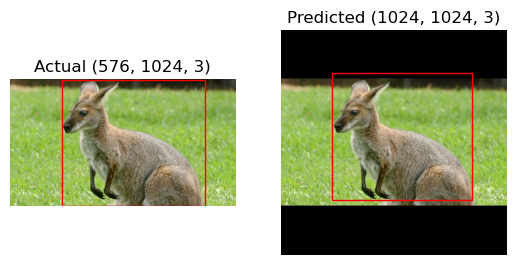

AP:  1.0
------------------------------------------------
Visualizing image:  25


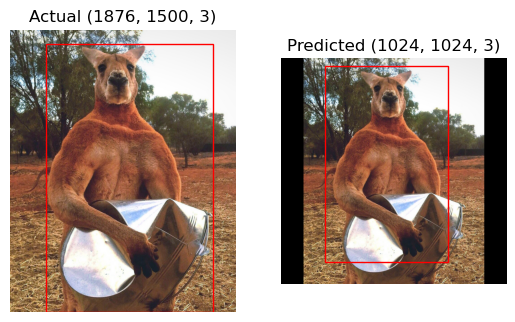

AP:  1.0
------------------------------------------------
Visualizing image:  26


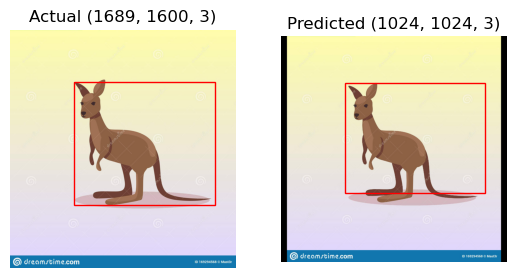

AP:  1.0
------------------------------------------------
Visualizing image:  27


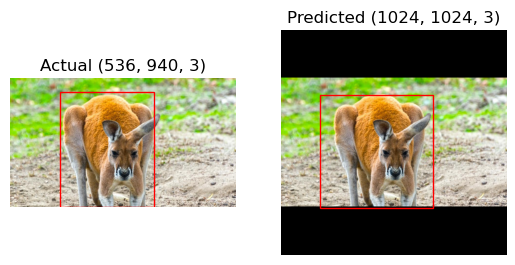

AP:  1.0
------------------------------------------------
Visualizing image:  28


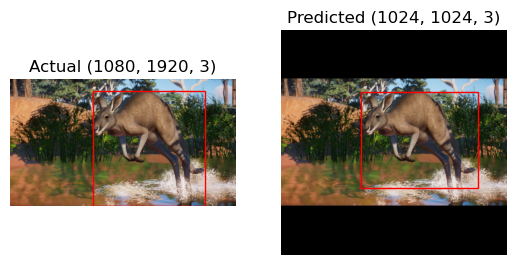

AP:  1.0
------------------------------------------------
Visualizing image:  29


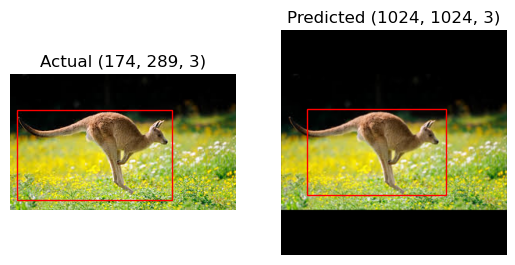

AP:  1.0


In [67]:
for image_id in test_set.image_ids:
	print('------------------------------------------------')
	print('Visualizing image: ', image_id)


	image_temp, yhat, ap = predict(test_set, image_id, config)
	image = test_set.load_image(image_id)
	true_masks, _ = test_set.load_mask(image_id)


	plot_pred(image, true_masks, yhat, image_temp)
	print('AP: ', ap)